In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

### Change to current directory ###
path ='/content/drive/MyDrive/Deep_learning/project/TransUnet_copy/'
transunet_model_path = '/content/drive/MyDrive/Deep_learning/project/trained_models/DINO_TransUNET_model - 20 epochs'
dino_model_path = '/content/drive/MyDrive/Deep_learning/project/trained_models/Our_DINO_TransUNET_model-20_epochs_patches'


Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Deep_learning/project/TransUnet_copy/

# Installs
!pip install ml_collections medpy

# Imports
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from tqdm import tqdm
from utils.utils import DiceLoss
from torchvision import transforms
from networks.vit_seg_modeling import VisionTransformer as ViT_seg
from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from datasets.dataset_sartorius import Sartorius_dataset, RandomGenerator
from google.colab.patches import cv2_imshow

/content/drive/MyDrive/Deep_learning/project/TransUnet_copy


In [3]:
# Dataset Definitions
train_base_dir = '/content/drive/MyDrive/Deep_learning/project/data/train_npz_patches'
test_base_dir = '/content/drive/MyDrive/Deep_learning/project/data/test_npz_patches'
list_dir = path + 'lists/lists_Sartorius_patches/'
img_size = 224    # original image size [520, 704]
rand_seed = 1234
num_classes = 2
n_skip = 3
vit_name = 'R50-ViT-B_16'
vit_patches_size = 16
z_spacing = 1
deterministic = True



db_train = Sartorius_dataset(base_dir=train_base_dir, list_dir=list_dir, split="train",transform=transforms.Compose([RandomGenerator(output_size=[img_size, img_size])]))

db_test = Sartorius_dataset(base_dir=test_base_dir, split="test", list_dir=list_dir,transform=transforms.Compose([RandomGenerator(output_size=[img_size, img_size])]))

def worker_init_fn(worker_id):
    random.seed(rand_seed + worker_id)


In [4]:
# Set random seeds for reproducibility
random.seed(rand_seed)
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)

# Set model Configuration
config_vit = CONFIGS_ViT_seg[vit_name]
config_vit.n_classes = num_classes
config_vit.n_skip = n_skip
if vit_name.find('R50') != -1:
    config_vit.patches.grid = (int(img_size / vit_patches_size), int(img_size / vit_patches_size))

# Load models
dino_model = torch.load(dino_model_path)
transunet_model = torch.load(transunet_model_path) 

dino_model.eval()
transunet_model.eval()

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (hybrid_model): ResNetV2(
        (root): Sequential(
          (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (gn): GroupNorm(32, 64, eps=1e-06, affine=True)
          (relu): ReLU(inplace=True)
        )
        (body): Sequential(
          (block1): Sequential(
            (unit1): PreActBottleneck(
              (gn1): GroupNorm(32, 64, eps=1e-06, affine=True)
              (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (gn2): GroupNorm(32, 64, eps=1e-06, affine=True)
              (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (gn3): GroupNorm(32, 256, eps=1e-06, affine=True)
              (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (relu): ReLU(inplace=True)
              (downsample): StdConv2d(64, 256, 

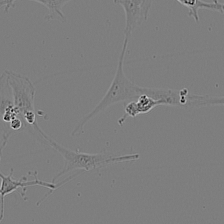

In [45]:
checkloader = DataLoader(db_train, batch_size=1, shuffle=True, num_workers=1, pin_memory=True,
                        worker_init_fn=worker_init_fn)

for image_data in checkloader:  
    image = image_data['image']
    label = image_data['label']


    break

image, label = image.cuda(), label.cuda()

dino_prediction = dino_model(image)
transunet_prediction = transunet_model(image)

np_label = label.cpu().detach().numpy()
np_image = image.cpu().detach().numpy()
np_dino_prediction = dino_prediction.cpu().detach().numpy()
np_transunet_prediction = transunet_prediction.cpu().detach().numpy()

cv2_imshow(np_image[0,0,:,:]*255)

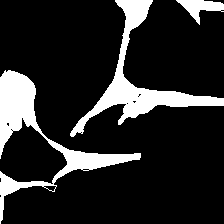

In [46]:
cv2_imshow(np_label[0,:,:]*255)

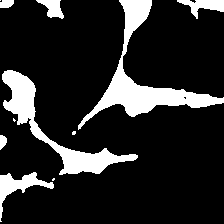

In [47]:
dino_pred = (np_dino_prediction - np.min(np_dino_prediction)) / (np.max(np_dino_prediction) - np.min(np_dino_prediction))

# Create final prediction from prediction scores
dino_final_pred = np.zeros_like(dino_pred[0,0,:,:])
dino_final_pred[dino_pred[0,0,:,:]<0.5] = 1

cv2_imshow(dino_final_pred*255)

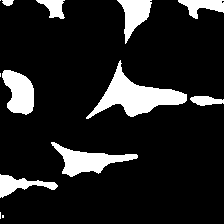

In [48]:
transunet_pred = (np_transunet_prediction - np.min(np_transunet_prediction)) / (np.max(np_transunet_prediction) - np.min(np_transunet_prediction))

# Create final prediction from prediction scores
transunet_final_pred = np.zeros_like(transunet_pred[0,0,:,:])
transunet_final_pred[transunet_pred[0,0,:,:]<0.5] = 1

cv2_imshow(transunet_final_pred*255)